# LightGBM SHAP for predicting use of thrombolysis

This model use 10 features:

* stroke_team_id
* stroke_severity
* prior_disability
* age
* infarction
* onset_to_arrival_time
* precise_onset_known
* onset_during_sleep
* arrival_to_scan_time
* afib_anticoagulant

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from dataclasses import dataclass
from lightgbm import LGBMClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './data/'
    output_folder = './output/'
    model_folder = './models'
    model_text = 'lgbm_decision_'
    notebook: str = '02_'

paths = Paths()

## Load data

In [3]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

# Limit by year
low_year = 2016
high_year = 2018
mask = (train['year'] >= low_year) & (train['year'] <= high_year)
train = train[mask]
train.drop('year', inplace=True, axis=1)
mask = (test['year'] >= low_year) & (test['year'] <= high_year)
test = test[mask]
test.drop('year', inplace=True, axis=1)

# Split X and y
X_train = train.drop('thrombolysis', axis=1)
X_test = test.drop('thrombolysis', axis=1)
y_train = train['thrombolysis']
y_test = test['thrombolysis']

# Get features
features = list(X_train)

In [4]:
features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

## Fit model

In [5]:
# Define model
model = LGBMClassifier(random_state=42, learning_rate=0.3)

# Fit model
model.fit(X_train, y_train)

# Get predictions
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

# Show overall accuracy
accuracy = np.mean(predicted == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.852


## Fit SHAP

In [6]:
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)
shap_values_extended[0]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


.values =
array([[ 7.72571415e-01, -7.72571415e-01],
       [ 6.93737452e-01, -6.93737452e-01],
       [-1.91935015e-01,  1.91935015e-01],
       [-2.92746274e-05,  2.92746274e-05],
       [-6.70132519e-01,  6.70132519e-01],
       [ 5.83930534e-01, -5.83930534e-01],
       [ 1.15182168e+00, -1.15182168e+00],
       [ 2.26061958e+00, -2.26061958e+00],
       [ 4.19545067e+00, -4.19545067e+00],
       [-1.24788543e-01,  1.24788543e-01]])

.base_values =
array([ 2.99829146, -2.99829146])

.data =
array([ 20. ,   3. ,   0. ,  72.5,   1. , 186. ,   0. ,   1. , 245. ,
         0. ])

## Show example waterfall plot

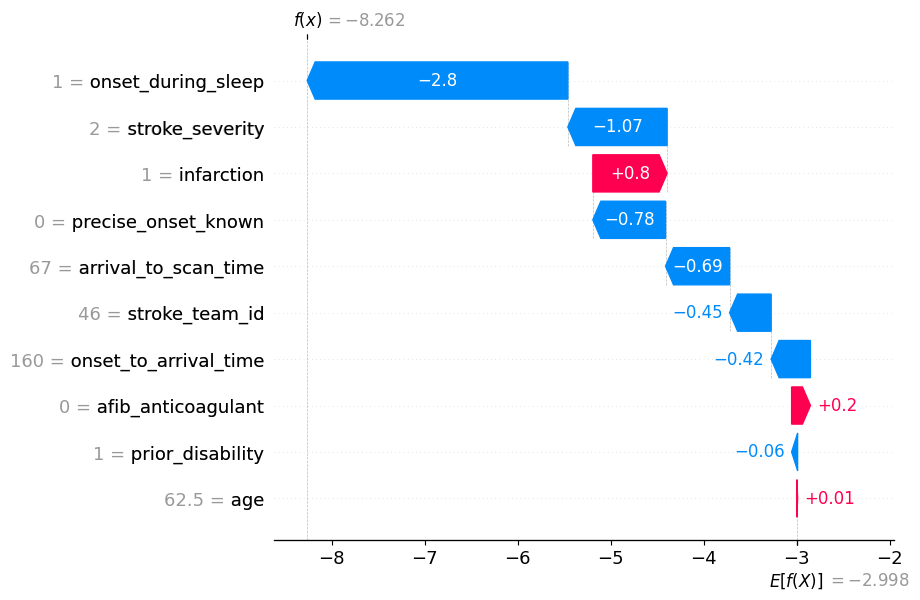

In [7]:
row = 5
class_index = 1

shap.waterfall_plot(shap.Explanation(
    values=shap_values[class_index][row],
    base_values=explainer.expected_value[class_index], data=X_test.iloc[row],
    feature_names=X_test.columns.tolist()))

## Beeswarm

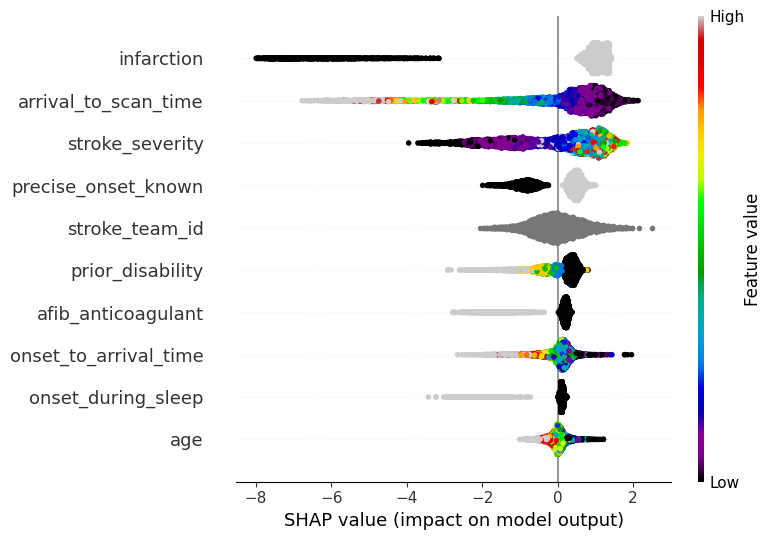

In [8]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values[1], 
                  features=X_test,
                  feature_names=features,
                  max_display=10,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

filename = paths.output_folder + paths.notebook + paths.model_text + 'beeswarm.jpg'
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Get mean absolute SHAP values

In [9]:
mean_abs_shap = pd.Series(
    np.mean(np.abs(shap_values[1]), axis=0),
    index=features)
mean_abs_shap.sort_values(inplace=True, ascending=False)
mean_abs_shap.round(4)

infarction               1.7752
arrival_to_scan_time     1.2096
stroke_severity          1.0220
precise_onset_known      0.6320
stroke_team_id           0.4741
prior_disability         0.4163
afib_anticoagulant       0.3664
onset_to_arrival_time    0.2991
onset_during_sleep       0.2142
age                      0.1672
dtype: float64

## Get stroke team SHAP

In [10]:
# DataFrame of hopsital SHAP values for all patients
all_team_shap = pd.DataFrame()
all_team_shap['team_id'] = X_test['stroke_team_id']
all_team_shap['SHAP'] = hospital_shap_values = shap_values[1][:,4]

# Get summary for teams
team_shap = pd.DataFrame()
team_shap['SHAP_mean'] = all_team_shap.groupby('team_id').mean()
team_shap['SHAP_std'] = all_team_shap.groupby('team_id').std()

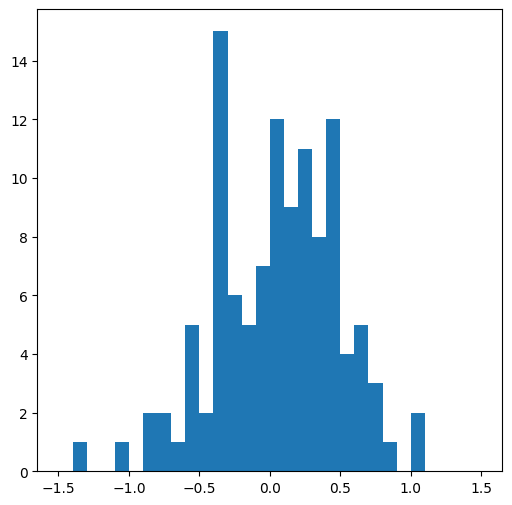

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(team_shap['SHAP_mean'], bins=np.arange(-1.5, 1.51, 0.1))

plt.show()

In [12]:
mean_shap = np.mean(team_shap['SHAP_mean'])
std_shap = np.std(team_shap['SHAP_mean'])
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP STDdev: {std_shap:0.3f}')

Mean hospital SHAP: 0.027
Mean hospital SHAP STDdev: 0.497
